In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -qq "/content/drive/My Drive/Masters/FourthSemester/CS577/Project/aptos2019-blindness-detection.zip"

In [1]:
import shutil
import math
import pandas as pd
%tensorflow_version 2.x
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from keras.models import Sequential
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Input,AveragePooling2D
from keras.layers import Activation,Flatten,Dropout,Dense,concatenate
from keras import Model
from keras.preprocessing.image import img_to_array,load_img
from keras import optimizers
from keras.applications import InceptionV3
import tensorflow.keras.backend as K
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import plot_model

In [6]:
def create_train_path(x):
  return './train_images/'+x+'.png'
def create_test_path(x):
  return './test_images/'+x+'.png'
def encode_categorical(x):
  labels = {0 : 'No DR',1 : 'Mild', 2 : 'Moderate',3 : 'Severe',4 : 'Proliferative DR'}
  return labels[x]
def plot_batch_images(generator):
  fig=plt.figure(figsize=(8, 8))
  for i,j in generator:
    for im in range(len(i)):
      fig.add_subplot(4, 5, im+1)
      plt.imshow(i[im])
    break
  plt.show()

In [7]:
train_df = pd.read_csv('./train.csv')
train_df['path'] = train_df['id_code'].apply(create_train_path)

test_df = pd.read_csv('./sample_submission.csv')
test_df['path'] = test_df['id_code'].apply(create_test_path)
test_df['encoded_diagnosis'] = test_df['diagnosis'].apply(encode_categorical)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_df['path'],train_df['diagnosis'], test_size=0.33, random_state=42)

In [9]:
train_df = pd.DataFrame([X_train,y_train]).T
train_df['encoded_diagnosis'] = train_df['diagnosis'].apply(encode_categorical)
val_df = pd.DataFrame([X_val,y_val]).T
val_df['encoded_diagnosis'] = val_df['diagnosis'].apply(encode_categorical)

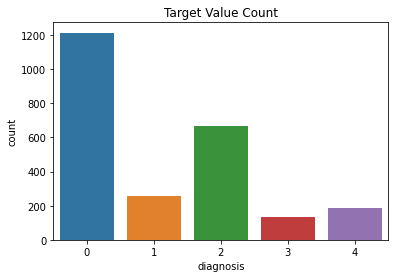

In [ ]:
plt.title('Target Value Count')
sns.countplot(x = train_df.diagnosis)
plt.show()

- Base Model

In [8]:
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)
val_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,x_col='path',y_col='encoded_diagnosis',class_mode='categorical',batch_size=20)
val_generator = val_datagen.flow_from_dataframe(dataframe = val_df,x_col='path',y_col='encoded_diagnosis',class_mode='categorical',batch_size=20)
test_generator = test_datagen.flow_from_dataframe(dataframe = test_df,x_col='path',y_col='encoded_diagnosis',class_mode='categorical',batch_size=20)


Found 2453 validated image filenames belonging to 5 classes.
Found 1209 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames belonging to 1 classes.


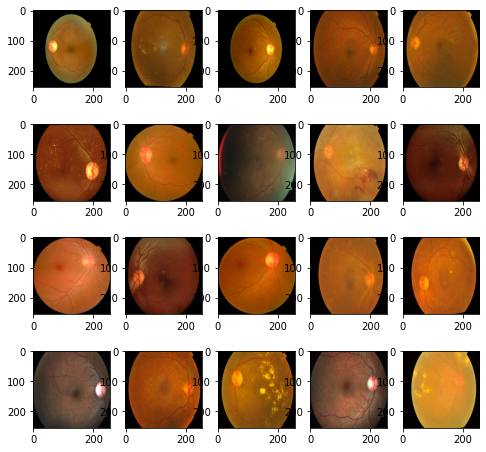

In [ ]:
plot_batch_images(train_generator)

In [ ]:
model = Sequential()
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 492032)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               251920896 
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

In [ ]:
model.compile(loss="categorical_crossentropy",optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=["accuracy"])
hist = model.fit_generator(train_generator,
                             steps_per_epoch=math.ceil(2453/20),
                             epochs=20,
                             validation_data=val_generator,
                             validation_steps=math.ceil(1209/20))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
123/123 [==============================] - 469s 4s/step - loss: 2.0304 - accuracy: 0.5959 - val_loss: 0.8969 - val_accuracy: 0.6849
Epoch 2/20
123/123 [==============================] - 466s 4s/step - loss: 0.7326 - accuracy: 0.7317 - val_loss: 0.7569 - val_accuracy: 0.7304
Epoch 3/20
123/123 [==============================] - 459s 4s/step - loss: 0.7277 - accuracy: 0.7191 - val_loss: 0.7459 - val_accuracy: 0.7436
Epoch 4/20
123/123 [==============================] - 455s 4s/step - loss: 0.6403 - accuracy: 0.7656 - val_loss: 0.7671 - val_accuracy: 0.7295
Epoch 5/20
123/123 [==============================] - 465s 4s/step - loss: 0.5952 - accuracy: 0.7827 - val_loss: 0.7236 - val_accuracy: 0.7461
Epoch 6/20
123/123 [==============================] - 461s 4s/step - loss: 0.5466 - accuracy: 0.8007 - val_loss: 0.7686 - val_accuracy: 0.7419
Epoch 7/20
123/123 [==============================] - 459s 4s/step - loss: 0.4861 - accuracy: 0.8230 - val_loss: 0.8068 - val_accuracy: 0.7353

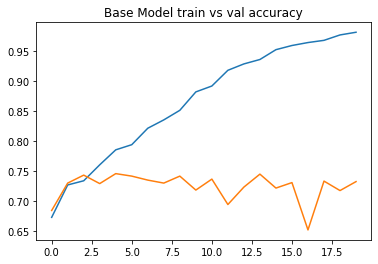

In [ ]:
plt.title('Base Model train vs val accuracy')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

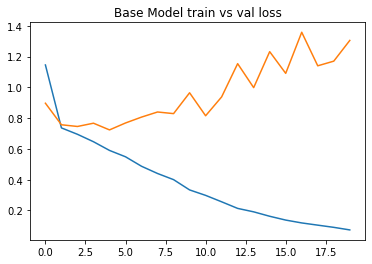

In [ ]:
plt.title('Base Model train vs val loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Masters/FourthSemester/CS577/Project/DR_Base_Model.hdf5')
model.save_weights('/content/drive/My Drive/Masters/FourthSemester/CS577/Project/DR_Base_Model.h5')

- Inception from scratch

In [13]:
def custom_iv3():
  input_size = Input(shape = (256,256,3))

  #conv_s2_1
  first_out = Conv2D(32,kernel_size=(3,3),strides=(2,2),name = 'Conv2D_S2')(input_size)
  first_out = BatchNormalization(name = 'Conv2D_S2_BN')(first_out)
  first_out = Activation('relu',name = 'Conv2D_S2_A')(first_out)

  #conv_s1_2
  second_out = Conv2D(32,kernel_size=(3,3),strides=(1,1),name = 'Conv2D_S1')(first_out)
  second_out = BatchNormalization(name = 'Conv2D_S1_BN')(second_out)
  second_out = Activation('relu',name = 'Conv2D_S1_A')(second_out)

  #conv_padded_3
  third_out = Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same',name = 'Conv2D_p_S1')(second_out)
  third_out = BatchNormalization(name = 'Conv2D_p_S1_BN')(third_out)
  third_out = Activation('relu',name = 'Conv2D_p_S1_A')(third_out)

  #pool_4
  pool_out = MaxPooling2D(pool_size=(3,3),strides=(2,2),name = 'MaxPool')(third_out)

  #conv_s1_5
  fifth_out = Conv2D(80,kernel_size=(3,3),strides=(1,1),name = 'Conv_S1_5')(pool_out)
  fifth_out = BatchNormalization(name = 'Conv_S1_5_BN')(fifth_out)
  fifth_out = Activation('relu',name = 'Conv_S1_5__A')(fifth_out)

  #conv_s2_6
  sixth_out = Conv2D(192,kernel_size=(3,3),strides=(2,2),name = 'Conv_S2_6')(fifth_out)
  sixth_out = BatchNormalization(name = 'Conv_S2_6_BN')(sixth_out)
  sixth_out = Activation('relu',name = 'Conv_S2_6_A')(sixth_out)

  #conv_s1_7
  seven_out = Conv2D(288,kernel_size=(3,3),strides=(1,1),name = 'Conv_S1_7',padding='same')(sixth_out)
  seven_out = BatchNormalization(name = 'Conv_S1_7_BN')(seven_out)
  seven_out = Activation('relu',name = 'Conv_S1_7_A')(seven_out)

  #3 Inception
  #part-1
  i3_five = Conv2D(128,kernel_size=(1,1),strides=(1,1),name = 'i3_1_1')(seven_out)
  i3_five = BatchNormalization()(i3_five)
  i3_five = Activation('relu')(i3_five)
  i3_five = Conv2D(128,kernel_size=(3,3),strides=(2,2),name = 'i3_1_3')(i3_five)
  i3_five = BatchNormalization()(i3_five)
  i3_five = Activation('relu')(i3_five)
  i3_five = Conv2D(192,kernel_size=(1,1),strides=(1,1),name = 'i3_1_3_2')(i3_five)
  i3_five = BatchNormalization()(i3_five)
  i3_five = Activation('relu')(i3_five)

  #part-2
  i3_three = Conv2D(384,kernel_size=(1,1),strides=(1,1),name = 'i3_2_1')(seven_out)
  i3_three = BatchNormalization()(i3_three)
  i3_three = Activation('relu')(i3_three)
  i3_three = Conv2D(192,kernel_size=(3,3),strides=(2,2),name = 'i3_2_3')(i3_three)
  i3_three = BatchNormalization()(i3_three)
  i3_three = Activation('relu')(i3_three)

  #part - 3
  i3_pool = AveragePooling2D(pool_size=(2,2),name = 'i3_3_1')(seven_out)
  i3_pool = Conv2D(384,kernel_size=(1,1))(i3_pool)
  i3_pool = BatchNormalization()(i3_pool)
  i3_pool = Activation('relu')(i3_pool)

  # #part-4
  # i3_one = Conv2D(192,kernel_size=(3,3),strides=(2,2))(seven_out)
  # i3_one = BatchNormalization()(i3_one)
  # i3_one = Activation('relu')(i3_one)

  mixed = concatenate([i3_five,i3_three,i3_pool])

  #second time
  #part-1
  i3_five = Conv2D(128,kernel_size=(1,1),strides=(1,1))(mixed)
  i3_five = BatchNormalization()(i3_five)
  i3_five = Activation('relu')(i3_five)
  i3_five = Conv2D(128,kernel_size=(3,3),strides=(1,1),padding='same')(i3_five)
  i3_five = BatchNormalization()(i3_five)
  i3_five = Activation('relu')(i3_five)
  i3_five = Conv2D(192,kernel_size=(1,1),strides=(1,1))(i3_five)
  i3_five = BatchNormalization()(i3_five)
  i3_five = Activation('relu')(i3_five)

  #part-2
  i3_three = Conv2D(384,kernel_size=(1,1),strides=(1,1))(mixed)
  i3_three = BatchNormalization()(i3_three)
  i3_three = Activation('relu')(i3_three)
  i3_three = Conv2D(192,kernel_size=(3,3),strides=(1,1),padding='same')(i3_three)
  i3_three = BatchNormalization()(i3_three)
  i3_three = Activation('relu')(i3_three)

  #part - 3
  i3_pool = AveragePooling2D(pool_size=(2,2))(seven_out)
  i3_pool = Conv2D(384,kernel_size=(1,1),padding='same')(i3_pool)
  i3_pool = BatchNormalization()(i3_pool)
  i3_pool = Activation('relu')(i3_pool)

  # #part-4
  # i3_one = Conv2D(192,kernel_size=(3,3),strides=(2,2))(seven_out)
  # i3_one = BatchNormalization()(i3_one)
  # i3_one = Activation('relu')(i3_one)

  mixed1 = concatenate([i3_five,i3_three,i3_pool])

  #third time
  #part-1
  i3_five = Conv2D(128,kernel_size=(1,1),strides=(1,1))(mixed1)
  i3_five = BatchNormalization()(i3_five)
  i3_five = Activation('relu')(i3_five)
  i3_five = Conv2D(128,kernel_size=(3,3),strides=(1,1),padding='same')(i3_five)
  i3_five = BatchNormalization()(i3_five)
  i3_five = Activation('relu')(i3_five)
  i3_five = Conv2D(192,kernel_size=(1,1),strides=(1,1))(i3_five)
  i3_five = BatchNormalization()(i3_five)
  i3_five = Activation('relu')(i3_five)

  #part-2
  i3_three = Conv2D(384,kernel_size=(1,1),strides=(1,1))(mixed)
  i3_three = BatchNormalization()(i3_three)
  i3_three = Activation('relu')(i3_three)
  i3_three = Conv2D(192,kernel_size=(3,3),strides=(1,1),padding='same')(i3_three)
  i3_three = BatchNormalization()(i3_three)
  i3_three = Activation('relu')(i3_three)

  #part - 3
  i3_pool = AveragePooling2D(pool_size=(2,2))(seven_out)
  i3_pool = Conv2D(384,kernel_size=(1,1),padding='same')(i3_pool)
  i3_pool = BatchNormalization()(i3_pool)
  i3_pool = Activation('relu')(i3_pool)

  # #part-4
  # i3_one = Conv2D(192,kernel_size=(3,3),strides=(2,2))(seven_out)
  # i3_one = BatchNormalization()(i3_one)
  # i3_one = Activation('relu')(i3_one)

  mixed2 = concatenate([i3_five,i3_three,i3_pool])

  #5 inception
  i5_five = Conv2D(320,kernel_size=(3,3),strides=(1,1))(mixed1)
  i5_five = BatchNormalization()(i5_five)
  i5_five = Activation('relu')(i5_five)
  i5_five = Conv2D(384,kernel_size=(1,3),strides=(2,2),padding='same')(i5_five)
  i5_five = BatchNormalization()(i5_five)
  i5_five = Activation('relu')(i5_five)
  i5_five = Conv2D(384,kernel_size=(3,1),strides=(1,1),padding='same')(i5_five)
  i5_five = BatchNormalization()(i5_five)
  i5_five = Activation('relu')(i5_five)
  i5_five = Conv2D(384,kernel_size=(1,3),strides=(1,1),padding='same')(i5_five)
  i5_five = BatchNormalization()(i5_five)
  i5_five = Activation('relu')(i5_five)
  i5_five = Conv2D(384,kernel_size=(3,1),strides=(1,1),padding='same')(i5_five)
  i5_five = BatchNormalization()(i5_five)
  i5_five = Activation('relu')(i5_five)
  
  #part-2
  i5_three = Conv2D(320,kernel_size=(3,3),strides=(1,1))(mixed1)
  i5_three = BatchNormalization()(i5_three)
  i5_three = Activation('relu')(i5_three)
  i5_three = Conv2D(384,kernel_size=(1,7),strides=(2,2),padding='same')(i5_three)
  i5_three = BatchNormalization()(i5_three)
  i5_three = Activation('relu')(i5_three)
  i5_three = Conv2D(384,kernel_size=(7,1),strides=(1,1),padding='same')(i5_three)
  i5_three = BatchNormalization()(i5_three)
  i5_three = Activation('relu')(i5_three)

  #part - 3
  i5_pool = AveragePooling2D(pool_size=(3,3),strides=(2,2))(mixed1)
  i5_pool = Conv2D(512,kernel_size=(1,1),padding='same')(i5_pool)
  i5_pool = BatchNormalization()(i5_pool)
  i5_pool = Activation('relu')(i5_pool)

  # #part-4
  # i5_one = Conv2D(320,kernel_size=(3,3),strides=(2,2),padding='same')(mixed1)
  # i5_one = BatchNormalization()(i5_one)
  # i5_one = Activation('relu')(i5_one)
  
  mixed3 = concatenate([i5_five,i5_three,i5_pool])

  #2 inception
  i2_five = Conv2D(320,kernel_size=(1,1),strides=(1,1))(mixed3)
  i2_five = BatchNormalization()(i2_five)
  i2_five = Activation('relu')(i2_five)
  i2_five = Conv2D(384,kernel_size=(3,3),strides=(1,1),padding='same')(i2_five)
  i2_five = BatchNormalization()(i2_five)
  i2_five = Activation('relu')(i2_five)
  i2_five_1 = Conv2D(384,kernel_size=(1,3),strides=(1,1),padding='same')(i2_five)
  i2_five_1 = BatchNormalization()(i2_five_1)
  i2_five_1 = Activation('relu')(i2_five_1)
  i2_five_2 = Conv2D(384,kernel_size=(3,1),strides=(1,1),padding='same')(i2_five)
  i2_five_2 = BatchNormalization()(i2_five_2)
  i2_five_2 = Activation('relu')(i2_five_2)

  #part-2
  i2_three = Conv2D(320,kernel_size=(3,3),strides=(1,1),padding='same')(mixed3)
  i2_three = BatchNormalization()(i2_three)
  i2_three = Activation('relu')(i2_three)
  i2_three_1 = Conv2D(384,kernel_size=(1,3),strides=(1,1),padding='same')(i2_three)
  i2_three_1 = BatchNormalization()(i5_three)
  i2_three_1 = Activation('relu')(i5_three)
  i2_three_2 = Conv2D(384,kernel_size=(3,1),strides=(1,1),padding='same')(i2_three)
  i2_three_2 = BatchNormalization()(i2_three_2)
  i2_three_2 = Activation('relu')(i2_three_2)

  #part - 3
  i2_pool = AveragePooling2D(pool_size=(2,2),strides = (1,1),padding='same')(mixed3)
  i2_pool = Conv2D(192,kernel_size=(1,1),padding='same')(i2_pool)
  i2_pool = BatchNormalization()(i2_pool)
  i2_pool = Activation('relu')(i2_pool)

  #part-4
  i2_one = Conv2D(320,kernel_size=(3,3),strides=(1,1),padding='same')(mixed3)
  i2_one = BatchNormalization()(i2_one)
  i2_one = Activation('relu')(i2_one)

  mixed4 = concatenate([i2_five_1,i2_five_2,i2_three_1,i2_three_2,i2_pool,i2_one])

  #second time
  i2_five = Conv2D(320,kernel_size=(1,1),strides=(1,1),padding='same')(mixed4)
  i2_five = BatchNormalization()(i2_five)
  i2_five = Activation('relu')(i2_five)
  i2_five = Conv2D(384,kernel_size=(3,3),strides=(1,1),padding='same')(i2_five)
  i2_five = BatchNormalization()(i2_five)
  i2_five = Activation('relu')(i2_five)
  i2_five_1 = Conv2D(384,kernel_size=(1,3),strides=(1,1),padding='same')(i2_five)
  i2_five_1 = BatchNormalization()(i2_five_1)
  i2_five_1 = Activation('relu')(i2_five_1)
  i2_five_2 = Conv2D(384,kernel_size=(3,1),strides=(1,1),padding='same')(i2_five)
  i2_five_2 = BatchNormalization()(i2_five_2)
  i2_five_2 = Activation('relu')(i2_five_2)

  #part-2
  i2_three = Conv2D(320,kernel_size=(3,3),strides=(1,1),padding='same')(mixed4)
  i2_three = BatchNormalization()(i2_three)
  i2_three = Activation('relu')(i2_three)
  i2_three_1 = Conv2D(384,kernel_size=(1,3),strides=(1,1),padding='same')(i2_three)
  i2_three_1 = BatchNormalization()(i5_three)
  i2_three_1 = Activation('relu')(i5_three)
  i2_three_2 = Conv2D(384,kernel_size=(3,1),strides=(1,1),padding='same')(i2_three)
  i2_three_2 = BatchNormalization()(i2_three_2)
  i2_three_2 = Activation('relu')(i2_three_2)

  #part - 3
  i2_pool = AveragePooling2D(pool_size=(2,2),strides = (1,1),padding='same')(mixed4)
  i2_pool = Conv2D(192,kernel_size=(1,1),padding='same')(i2_pool)
  i2_pool = BatchNormalization()(i2_pool)
  i2_pool = Activation('relu')(i2_pool)

  #part-4
  i2_one = Conv2D(320,kernel_size=(1,1),strides=(1,1))(mixed4)
  i2_one = BatchNormalization()(i2_one)
  i2_one = Activation('relu')(i2_one)

  mixed5 = concatenate([i2_five_1,i2_five_2,i2_three_1,i2_three_2,i2_pool,i2_one])

  flat = AveragePooling2D((6,6))(mixed5)

  #fully connected
  fc = Flatten()(flat)
  out = Dense(5,activation='softmax')(fc)

  
  return Model(inputs = [input_size], outputs = [out]) 

In [77]:
model = custom_iv3()

In [78]:
model.compile(loss="categorical_crossentropy",optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=["accuracy"])
hist = model.fit_generator(train_generator,
                             steps_per_epoch=math.ceil(2453/20),
                             epochs=20,
                             validation_data=val_generator,
                             validation_steps=math.ceil(1209/20))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
123/123 [==============================] - 527s 4s/step - loss: 1.1491 - accuracy: 0.5949 - val_loss: 1.6150 - val_accuracy: 0.2738
Epoch 2/20
123/123 [==============================] - 482s 4s/step - loss: 0.8238 - accuracy: 0.7106 - val_loss: 1.6182 - val_accuracy: 0.2738
Epoch 3/20
123/123 [==============================] - 477s 4s/step - loss: 0.7303 - accuracy: 0.7337 - val_loss: 1.4710 - val_accuracy: 0.2680
Epoch 4/20
123/123 [==============================] - 467s 4s/step - loss: 0.7199 - accuracy: 0.7334 - val_loss: 1.1790 - val_accuracy: 0.5616
Epoch 5/20
123/123 [==============================] - 466s 4s/step - loss: 0.6610 - accuracy: 0.7638 - val_loss: 0.7792 - val_accuracy: 0.7105
Epoch 6/20
123/123 [==============================] - 460s 4s/step - loss: 0.6176 - accuracy: 0.7716 - val_loss: 0.7281 - val_accuracy: 0.7510
Epoch 7/20
123/123 [==============================] - 461s 4s/step - loss: 0.5494 - accuracy: 0.8009 - val_loss: 0.6933 - val_accuracy: 0.7502

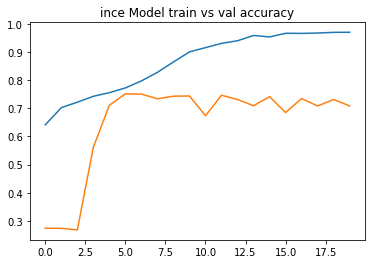

In [79]:
plt.title('ince Model train vs val accuracy')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

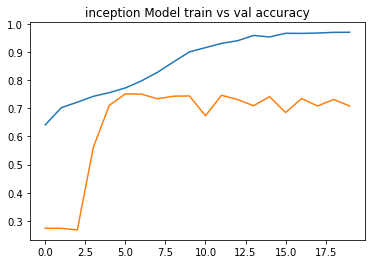

In [80]:
plt.title('inception Model train vs val loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [81]:
model.save('/content/drive/My Drive/Masters/FourthSemester/CS577/Project/DR_custom_inception_Model.hdf5')
model.save_weights('/content/drive/My Drive/Masters/FourthSemester/CS577/Project/DR_custom_inception_Model.h5')

- Data Augmented

In [10]:
train_datagen=ImageDataGenerator(rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)
val_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,x_col='path',y_col='encoded_diagnosis',class_mode='categorical',batch_size=20)
val_generator = val_datagen.flow_from_dataframe(dataframe = val_df,x_col='path',y_col='encoded_diagnosis',class_mode='categorical',batch_size=20)
test_generator = test_datagen.flow_from_dataframe(dataframe = test_df,x_col='path',y_col='encoded_diagnosis',class_mode='categorical',batch_size=20)


Found 2453 validated image filenames belonging to 5 classes.
Found 1209 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames belonging to 1 classes.


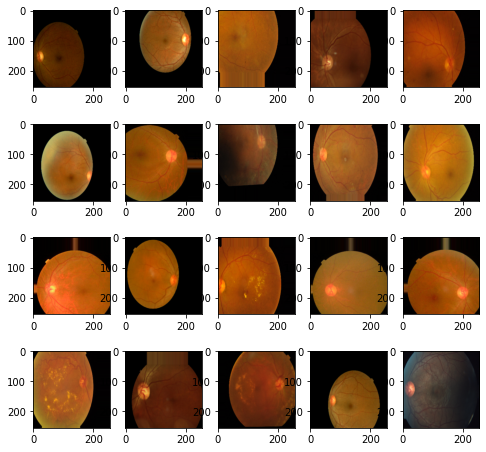

In [ ]:
fig=plt.figure(figsize=(8, 8))
for i,j in train_generator:
  for im in range(len(i)):
    fig.add_subplot(4, 5, im+1)
    plt.imshow(i[im])
  break
plt.show()

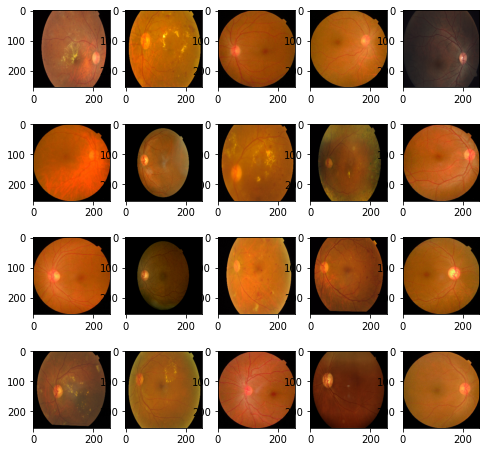

In [ ]:
fig=plt.figure(figsize=(8, 8))
for i,j in val_generator:
  for im in range(len(i)):
    fig.add_subplot(4, 5, im+1)
    plt.imshow(i[im])
  break
plt.show()

In [83]:
model = custom_iv3()
model.compile(loss="categorical_crossentropy",optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=["accuracy"])
hist = model.fit_generator(train_generator,
                             steps_per_epoch=math.ceil(2453/20),
                             epochs=20,
                             validation_data=val_generator,
                             validation_steps=math.ceil(1209/20))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
123/123 [==============================] - 502s 4s/step - loss: 1.2405 - accuracy: 0.5528 - val_loss: 2.4408 - val_accuracy: 0.2738
Epoch 2/20
123/123 [==============================] - 492s 4s/step - loss: 0.9407 - accuracy: 0.6634 - val_loss: 1.8920 - val_accuracy: 0.1538
Epoch 3/20
123/123 [==============================] - 490s 4s/step - loss: 0.8669 - accuracy: 0.6957 - val_loss: 2.9445 - val_accuracy: 0.1125
Epoch 4/20
123/123 [==============================] - 497s 4s/step - loss: 0.8316 - accuracy: 0.7032 - val_loss: 1.1101 - val_accuracy: 0.5682
Epoch 5/20
123/123 [==============================] - 496s 4s/step - loss: 0.8348 - accuracy: 0.7042 - val_loss: 0.8136 - val_accuracy: 0.7179
Epoch 6/20
123/123 [==============================] - 505s 4s/step - loss: 0.7597 - accuracy: 0.7120 - val_loss: 0.8478 - val_accuracy: 0.7237
Epoch 7/20
123/123 [==============================] - 507s 4s/step - loss: 0.8029 - accuracy: 0.7130 - val_loss: 0.7897 - val_accuracy: 0.7179

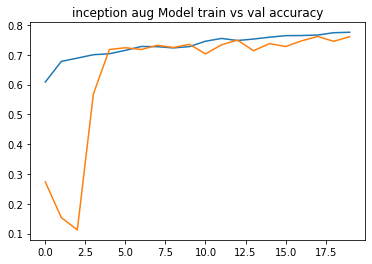

In [84]:
plt.title('inception aug Model train vs val accuracy')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

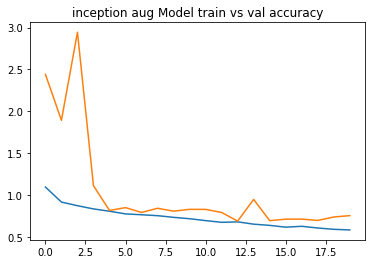

In [87]:
plt.title('inception aug Model train vs val accuracy')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [86]:
model.save('/content/drive/My Drive/Masters/FourthSemester/CS577/Project/DR_custom_inception_aug_Model.hdf5')
model.save_weights('/content/drive/My Drive/Masters/FourthSemester/CS577/Project/DR_custom_inception_aug_Model.h5')

- Keras Pre trained model with data augmentation

In [ ]:
inception_base = InceptionV3()

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
inception_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
inception_base.trainable = False
model = Sequential()
model.add(inception_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               37749248  
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 59,554,597
Trainable params: 37,751,813
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(loss="categorical_crossentropy",optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=["accuracy"])
hist = model.fit_generator(train_generator,
                             steps_per_epoch=math.ceil(2453/20),
                             epochs=20,
                             validation_data=val_generator,
                             validation_steps=math.ceil(1209/20))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
123/123 [==============================] - 489s 4s/step - loss: 5.5517 - accuracy: 0.5090 - val_loss: 1.3317 - val_accuracy: 0.6609
Epoch 2/20
123/123 [==============================] - 482s 4s/step - loss: 1.2026 - accuracy: 0.6597 - val_loss: 0.9638 - val_accuracy: 0.7089
Epoch 3/20
123/123 [==============================] - 486s 4s/step - loss: 1.1853 - accuracy: 0.6724 - val_loss: 1.0537 - val_accuracy: 0.7237
Epoch 4/20
123/123 [==============================] - 485s 4s/step - loss: 1.0561 - accuracy: 0.7069 - val_loss: 1.4003 - val_accuracy: 0.5881
Epoch 5/20
123/123 [==============================] - 483s 4s/step - loss: 1.0019 - accuracy: 0.6877 - val_loss: 1.0764 - val_accuracy: 0.6940
Epoch 6/20
123/123 [==============================] - 484s 4s/step - loss: 0.8888 - accuracy: 0.7105 - val_loss: 0.9612 - val_accuracy: 0.7337
Epoch 7/20
123/123 [==============================] - 487s 4s/step - loss: 0.7666 - accuracy: 0.7528 - val_loss: 1.4081 - val_accuracy: 0.4963

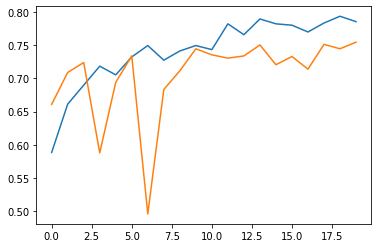

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

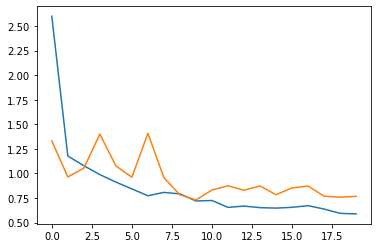

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [ ]:
inception_base.trainable = False

In [ ]:
model.compile(loss="categorical_crossentropy",optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=["accuracy"])
hist = model.fit_generator(train_generator,
                             steps_per_epoch=math.ceil(2453/20),
                             epochs=20,
                             validation_data=val_generator,
                             validation_steps=math.ceil(1209/20))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
123/123 [==============================] - 488s 4s/step - loss: 0.6450 - accuracy: 0.7803 - val_loss: 0.7729 - val_accuracy: 0.7345
Epoch 2/20
123/123 [==============================] - 478s 4s/step - loss: 0.5929 - accuracy: 0.7893 - val_loss: 0.8169 - val_accuracy: 0.7486
Epoch 3/20
123/123 [==============================] - 483s 4s/step - loss: 0.5917 - accuracy: 0.7846 - val_loss: 0.6970 - val_accuracy: 0.7568
Epoch 4/20
123/123 [==============================] - 480s 4s/step - loss: 0.5890 - accuracy: 0.7920 - val_loss: 0.8576 - val_accuracy: 0.7452
Epoch 5/20
123/123 [==============================] - 481s 4s/step - loss: 0.5693 - accuracy: 0.7913 - val_loss: 0.7490 - val_accuracy: 0.7270
Epoch 6/20
123/123 [==============================] - 479s 4s/step - loss: 0.5085 - accuracy: 0.8134 - val_loss: 0.7387 - val_accuracy: 0.7477
Epoch 7/20
123/123 [==============================] - 489s 4s/step - loss: 0.5176 - accuracy: 0.8077 - val_loss: 0.7277 - val_accuracy: 0.7659

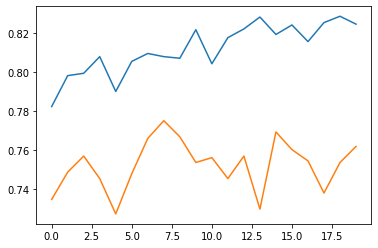

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

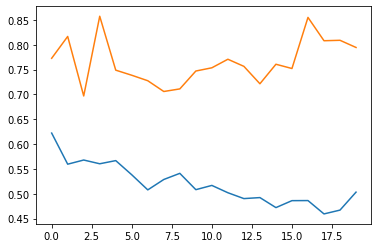

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])